### Imports

In [1]:
import pandas as pd
import re
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib
from geopy import distance

In [2]:
font = {'size'   : 14}

matplotlib.rc('font', **font)

### Loading Bike Station Location Data

In [3]:
maps_df = pd.read_csv('./data/bikeshare_stations.csv')

In [4]:
maps_df.head()

,station_id,name,lat,lon
0,7000.0,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001.0,Lower Jarvis St / The Esplanade,43.647992,-79.370907
2,7002.0,St. George St / Bloor St W,43.667333,-79.399429
3,7003.0,Madison Ave / Bloor St W,43.667158,-79.402761
4,7004.0,University Ave / Elm St,43.656518,-79.389099


### Visualizing the Bike Stations

In [5]:
BBox = ((maps_df.lon.min(), maps_df.lon.max(), maps_df.lat.min(), maps_df.lat.max()))
BBox

(-79.48674, -79.28145500000001, 43.61868, 43.716652)

In [6]:
map_image = plt.imread('./map.png', 0)

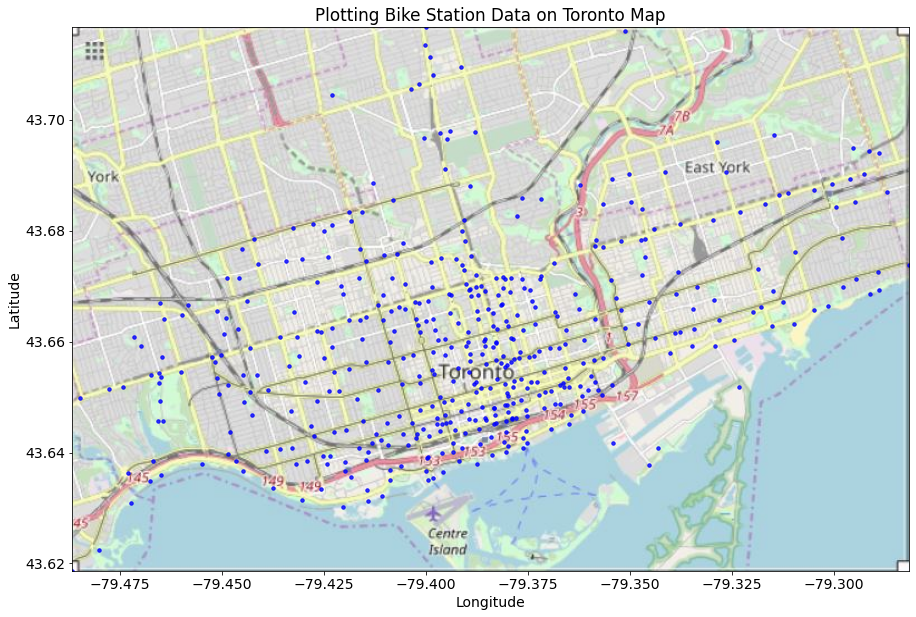

In [7]:
plt.figure(figsize = (15, 10))
plt.scatter(maps_df.lon, maps_df.lat, zorder = 1, alpha = 0.8, c = 'blue', s = 12)
plt.title('Plotting Bike Station Data on Toronto Map')
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.imshow(map_image, zorder = 0, extent = BBox, aspect = 'auto');
plt.savefig('visualization/bike_stations.png')

### Loading the Cyclists Data

In [8]:
cyclist_df = pd.read_csv('./data/cyclist_data.csv')

In [9]:
cyclist_df.head()

,trip_id,trip_start_time,trip_duration_seconds,user_type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to
0,712382,31-12-2016 20:00,223,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903
1,719668,06-01-2017 20:32,162,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903
2,720949,08-01-2017 20:52,194,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903
3,722433,09-01-2017 20:28,159,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903
4,740570,20-01-2017 12:53,222,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903


In [10]:
cyclist_df.columns

Index(['trip_id', 'trip_start_time', 'trip_duration_seconds', 'user_type',
       'station_id_from', 'name_from', 'lat_from', 'lon_from', 'station_id_to',
       'name_to', 'lat_to', 'lon_to'],
      dtype='object')

### Some Pre-Processing on The Data

In [12]:
#Converting to Datetime
cyclist_df['trip_start_time'] = pd.to_datetime(cyclist_df['trip_start_time'], dayfirst = True)

In [13]:
#Extracting Hour, Day, Week, Day Name & Month Name from Trip Start Time
cyclist_df['hour'] = cyclist_df['trip_start_time'].dt.hour.values
cyclist_df['week'] = cyclist_df['trip_start_time'].dt.week.values
cyclist_df['day'] = cyclist_df['trip_start_time'].dt.day.values
cyclist_df['day_name'] = cyclist_df['trip_start_time'].dt.day_name()
cyclist_df['month_name'] = cyclist_df['trip_start_time'].dt.month_name()

In [14]:
#Setting The Trip Start Time as Index
cyclist_df.index = cyclist_df.trip_start_time.dt.date.values
cyclist_df.index.name = 'index'

#Setting Dummy Value Count Column for Each Row to 1
cyclist_df['value'] = 1

In [15]:
cyclist_df.head()

,trip_id,trip_start_time,trip_duration_seconds,user_type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to,hour,week,day,day_name,month_name,value
index,,,,,,,,,,,,,,,,,,
2016-12-31,712382,2016-12-31 20:00:00,223,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903,20,52,31,Saturday,December,1
2017-01-06,719668,2017-01-06 20:32:00,162,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903,20,1,6,Friday,January,1
2017-01-08,720949,2017-01-08 20:52:00,194,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903,20,1,8,Sunday,January,1
2017-01-09,722433,2017-01-09 20:28:00,159,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903,20,2,9,Monday,January,1
2017-01-20,740570,2017-01-20 12:53:00,222,Member,7051,Wellesley St E / Yonge St Green P,43.66506,-79.38357,7089,Church St / Wood St,43.662712,-79.379903,12,3,20,Friday,January,1


## Users Information

### Types of Users & Their Contribution

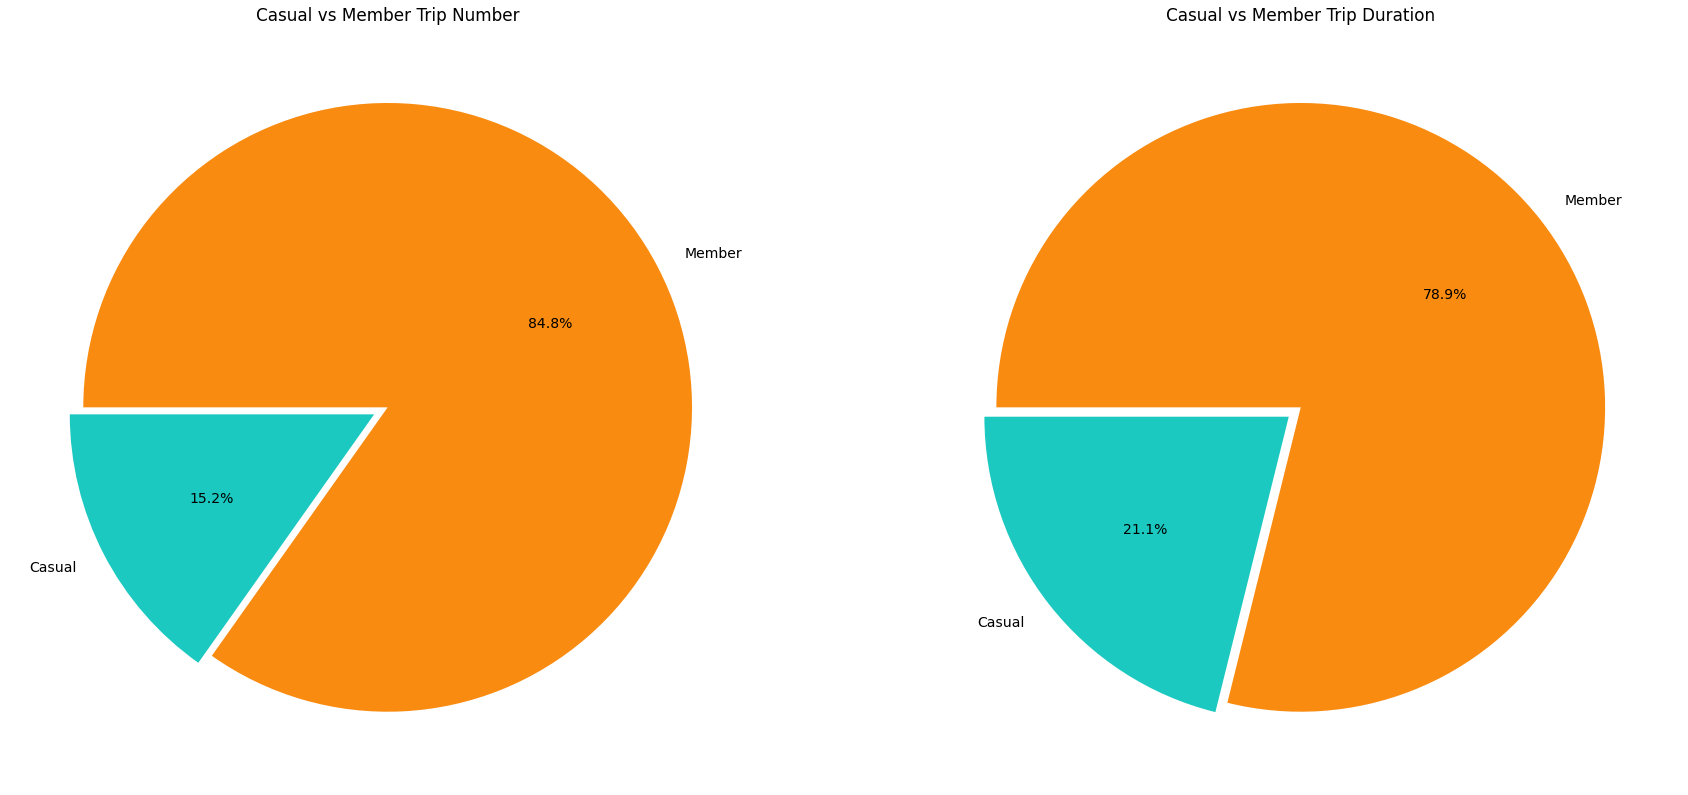

In [16]:
users = cyclist_df.groupby(['user_type']).sum() #Grouping Data by User Type
colors = ['#1CC9C0', '#F98B10'] #Defining Colours to be Used

plt.figure(figsize = (30,15));

#Plotting Percentage of Rides by User Type
plt.subplot(1,2,1)
plt.pie(users.value.values, startangle = 180, labels = users.index, autopct = '%.1f%%', explode = (.05,0), colors = colors);
plt.title('Casual vs Member Trip Number');
plt.xlabel

#Plotting Percentage of Trip Duration by User Type
plt.subplot(1,2,2)
plt.pie(users.trip_duration_seconds.values, startangle = 180, labels = users.index, autopct = '%.1f%%', explode = (.05,0), colors = colors);
plt.title('Casual vs Member Trip Duration');
plt.savefig('visualization/member_types.png')

## Finding Busiest Bike Stations

### Busiest Departing Bike Station for Members

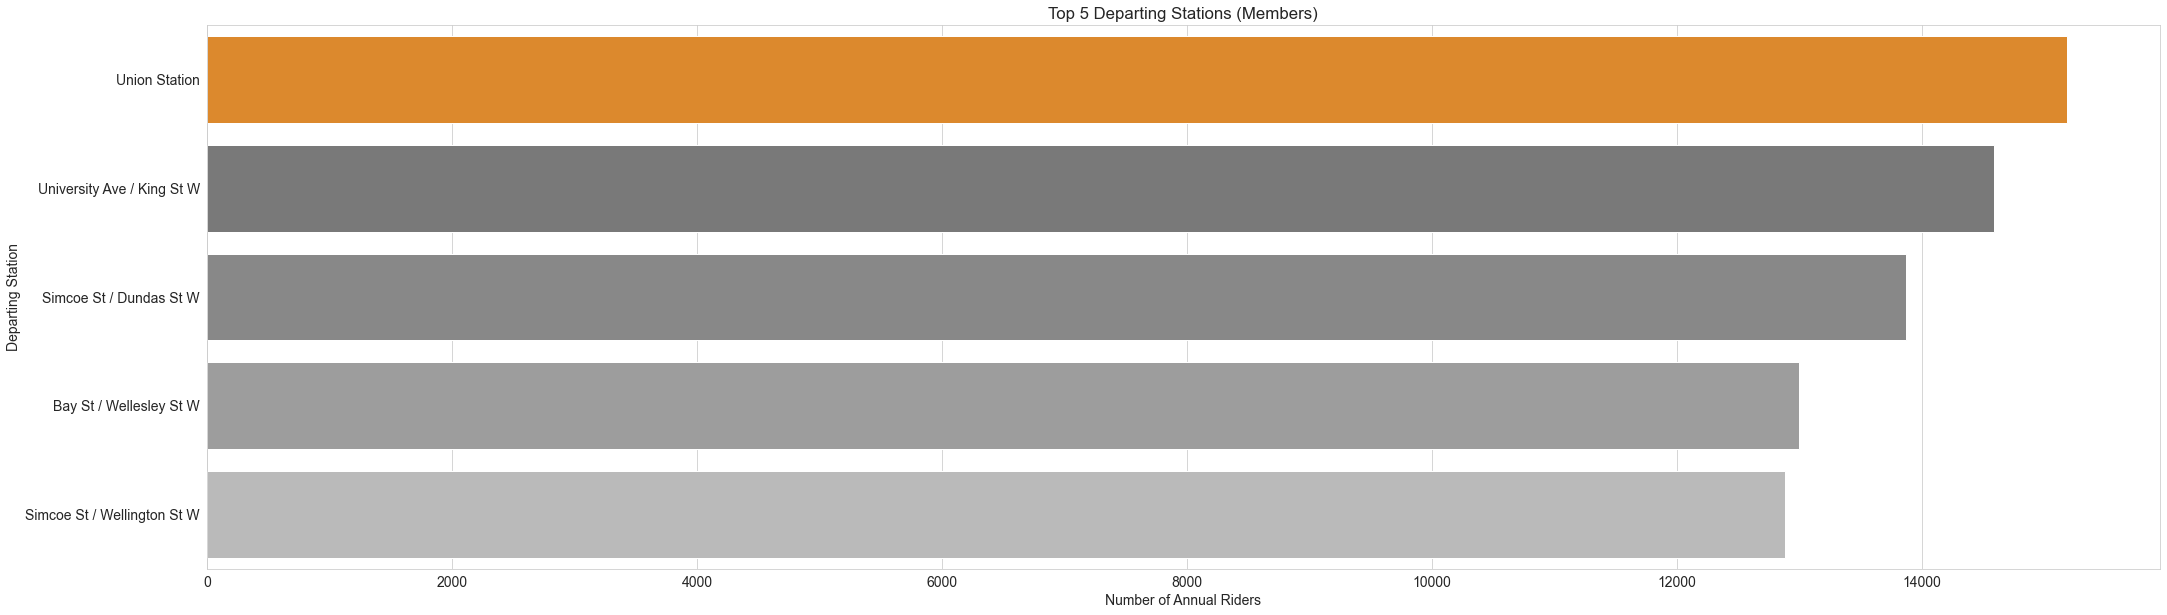

In [17]:
plt.figure(figsize = (35, 10))
sns.set_style("whitegrid")

#Using Seaborn Count Plot
sns.countplot(y = cyclist_df[cyclist_df['user_type'] == 'Member']['name_from'], data = cyclist_df, 
              palette = ['#F98B10', '#797979', '#888888', '#9D9D9D', '#BABABA'], 
              order = cyclist_df[cyclist_df['user_type'] == 'Member']['name_from'].value_counts().index[:5])

plt.ylabel('Departing Station')
plt.xlabel('Number of Annual Riders')
plt.title('Top 5 Departing Stations (Members)');
plt.savefig('visualization/busiest_departing.png')

### Busiest Arriving Bike Station for Members

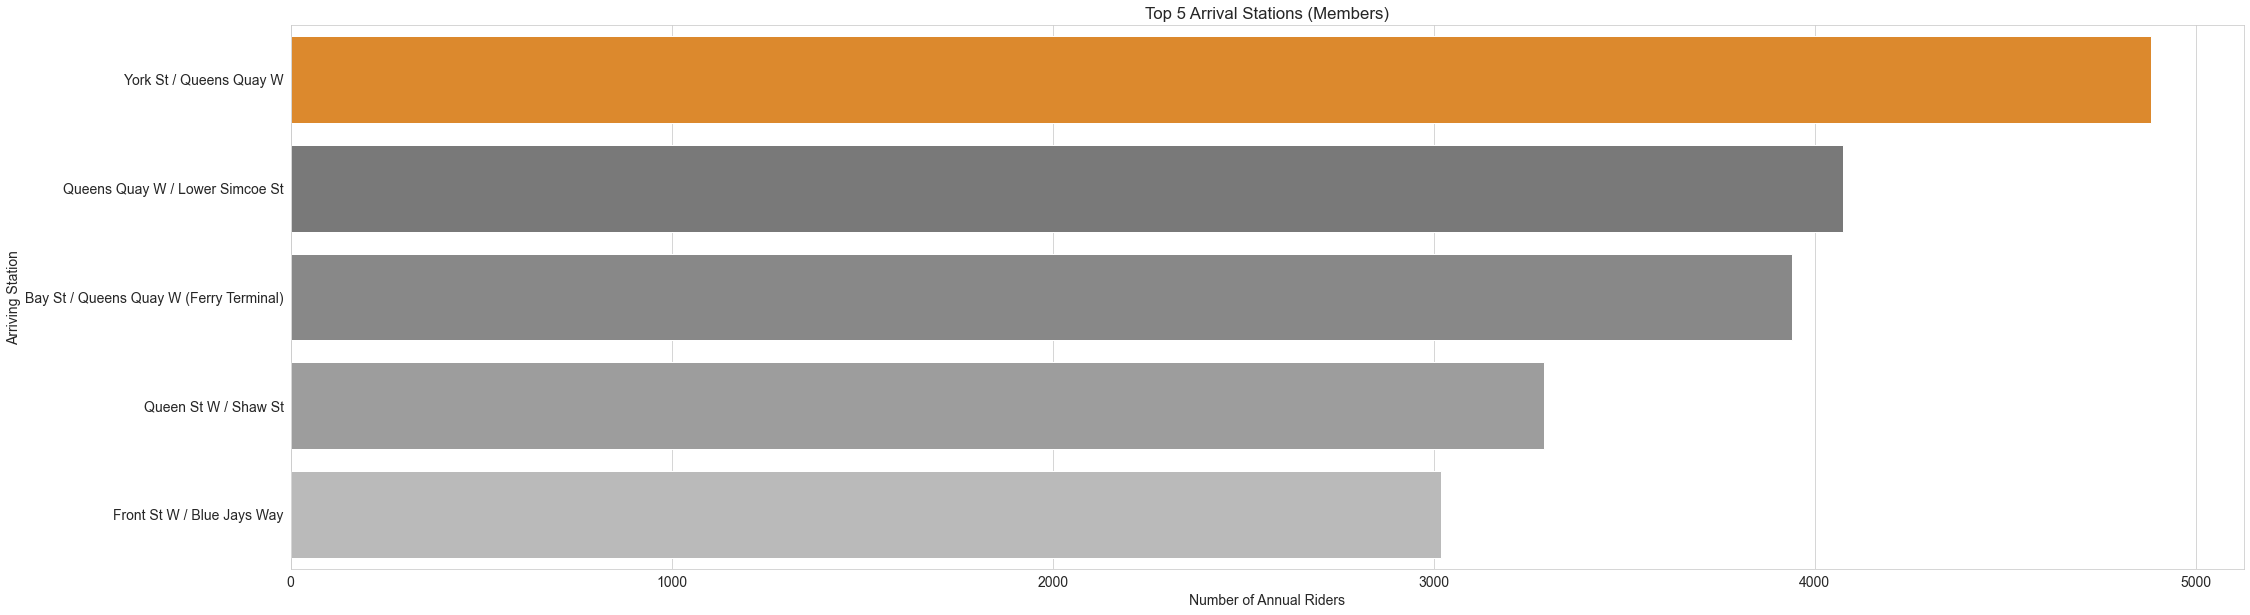

In [18]:
plt.figure(figsize = (35, 10))
sns.set_style("whitegrid")

#Using Seaborn Count Plot
sns.countplot(y = cyclist_df[cyclist_df['user_type'] == 'Casual']['name_to'], data = cyclist_df, 
              palette = ['#F98B10', '#797979', '#888888', '#9D9D9D', '#BABABA'], 
              order = cyclist_df[cyclist_df['user_type'] == 'Casual']['name_to'].value_counts().index[:5])

plt.ylabel('Arriving Station')
plt.xlabel('Number of Annual Riders')
plt.title('Top 5 Arrival Stations (Members)');
plt.savefig('visualization/busiest_arriving.png')

### Plotting Busiest Departing and Arriving Stations on the Toronto Map

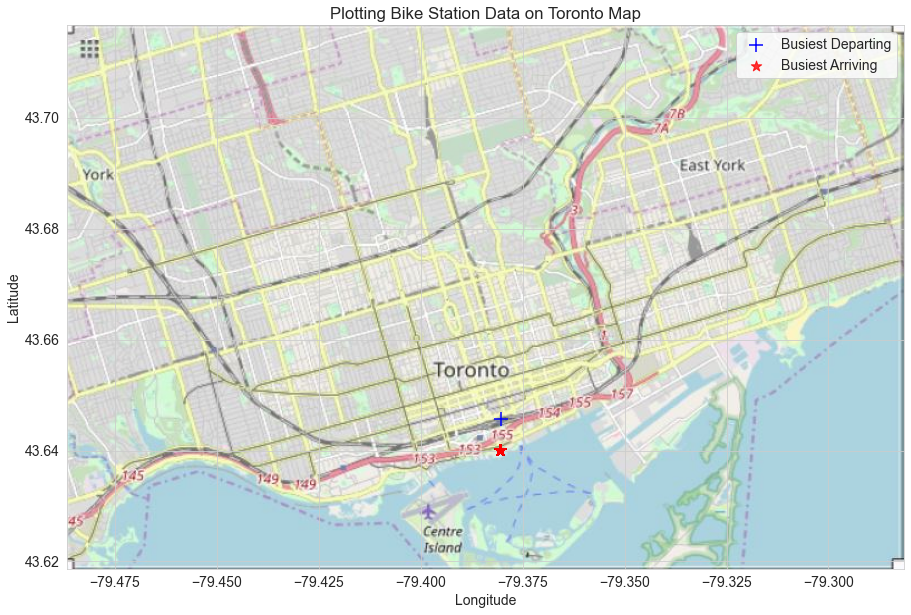

In [21]:
plt.figure(figsize = (15, 10))

#Using Scatter Plot to PLot Busiest Bike Stations on the Map
plt.scatter(cyclist_df[cyclist_df['name_from'] == 'Union Station'].lon_from.unique()[0], 
            cyclist_df[cyclist_df['name_from'] == 'Union Station'].lat_from.unique()[0], 
            zorder = 1, alpha = 1.0, c = 'blue', s = 200, marker = '+', label = 'Busiest Departing')
plt.scatter(cyclist_df[cyclist_df['name_to'] == 'York St / Queens Quay W'].lon_to, 
            cyclist_df[cyclist_df['name_to'] == 'York St / Queens Quay W'].lat_to, 
            zorder = 1, alpha = 0.8, c = 'red', s = 120, marker = '*', label = 'Busiest Arriving')

plt.title('Plotting Bike Station Data on Toronto Map')
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.imshow(map_image, zorder = 0, extent = BBox, aspect = 'auto')
plt.savefig('visualization/busiest_departing_arriving.png')

### Finding Distance Travelled for Each Trip Using Latitude & Logitude

In [22]:
#Using Geopy Distance Function to Calculate Distances
cyclist_df['Distance'] = cyclist_df.apply(lambda x: distance.distance((x['lat_from'], x['lon_from']), (x['lat_to'], x['lon_to'])).km * 1000, axis=1)

### Trip Duration & Distance of Trip Distribution Graph

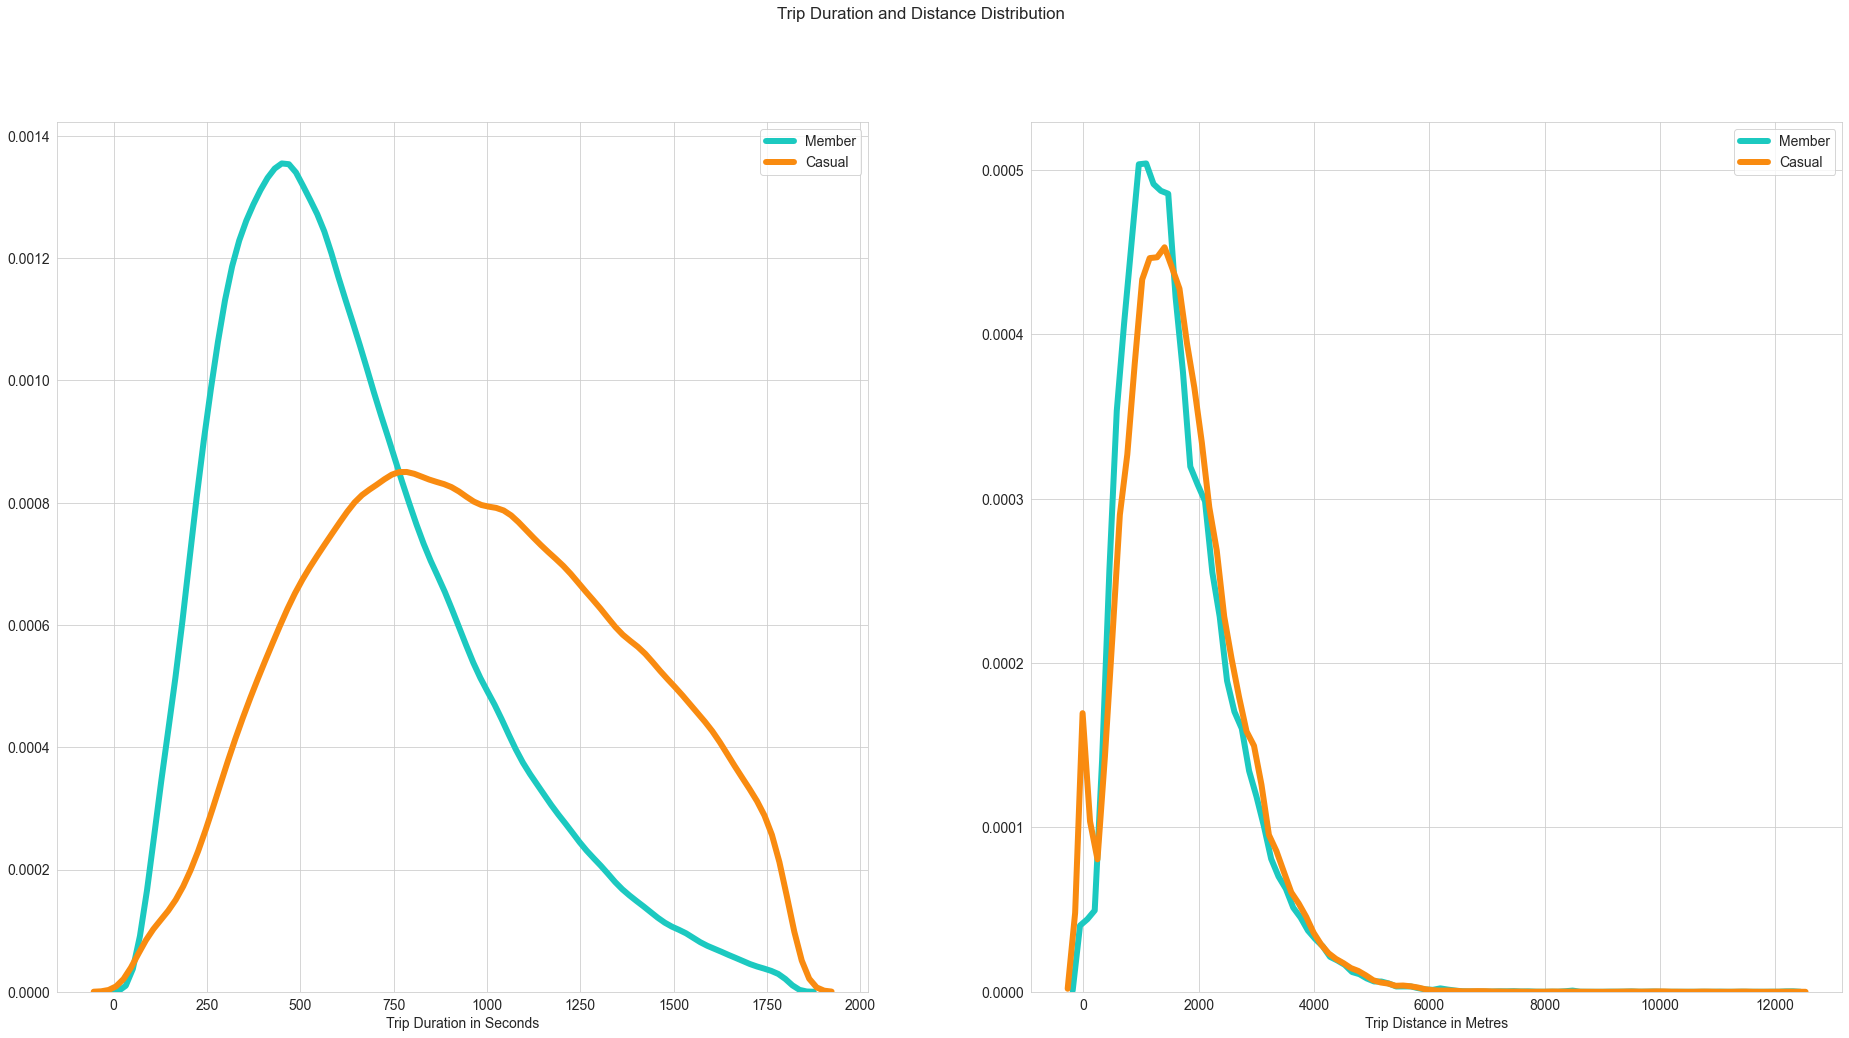

In [23]:
colors = ['#1CC9C0', '#F98B10'] #Setting Colours to be Used

fig, ax = plt.subplots(1, 2, figsize = (32, 16))
sns.set_style("whitegrid")

#Plotting Distributon Plots for Each User type
for i, col in enumerate(['trip_duration_seconds', 'Distance']):
    for j, user in enumerate(cyclist_df['user_type'].unique()):
        sns.distplot(cyclist_df[cyclist_df['user_type'] == user][col], hist = False, ax = ax[i], label = user, 
                     kde_kws = dict(linewidth = 6), color = colors[j])

plt.suptitle('Trip Duration and Distance Distribution')
ax[0].set_xlabel('Trip Duration in Seconds')
ax[1].set_xlabel('Trip Distance in Metres')
plt.legend();
plt.savefig('visualization/distance_duration.png')

### Daily Activity Heatmap - Members - Hour of Day vs Trip Duration

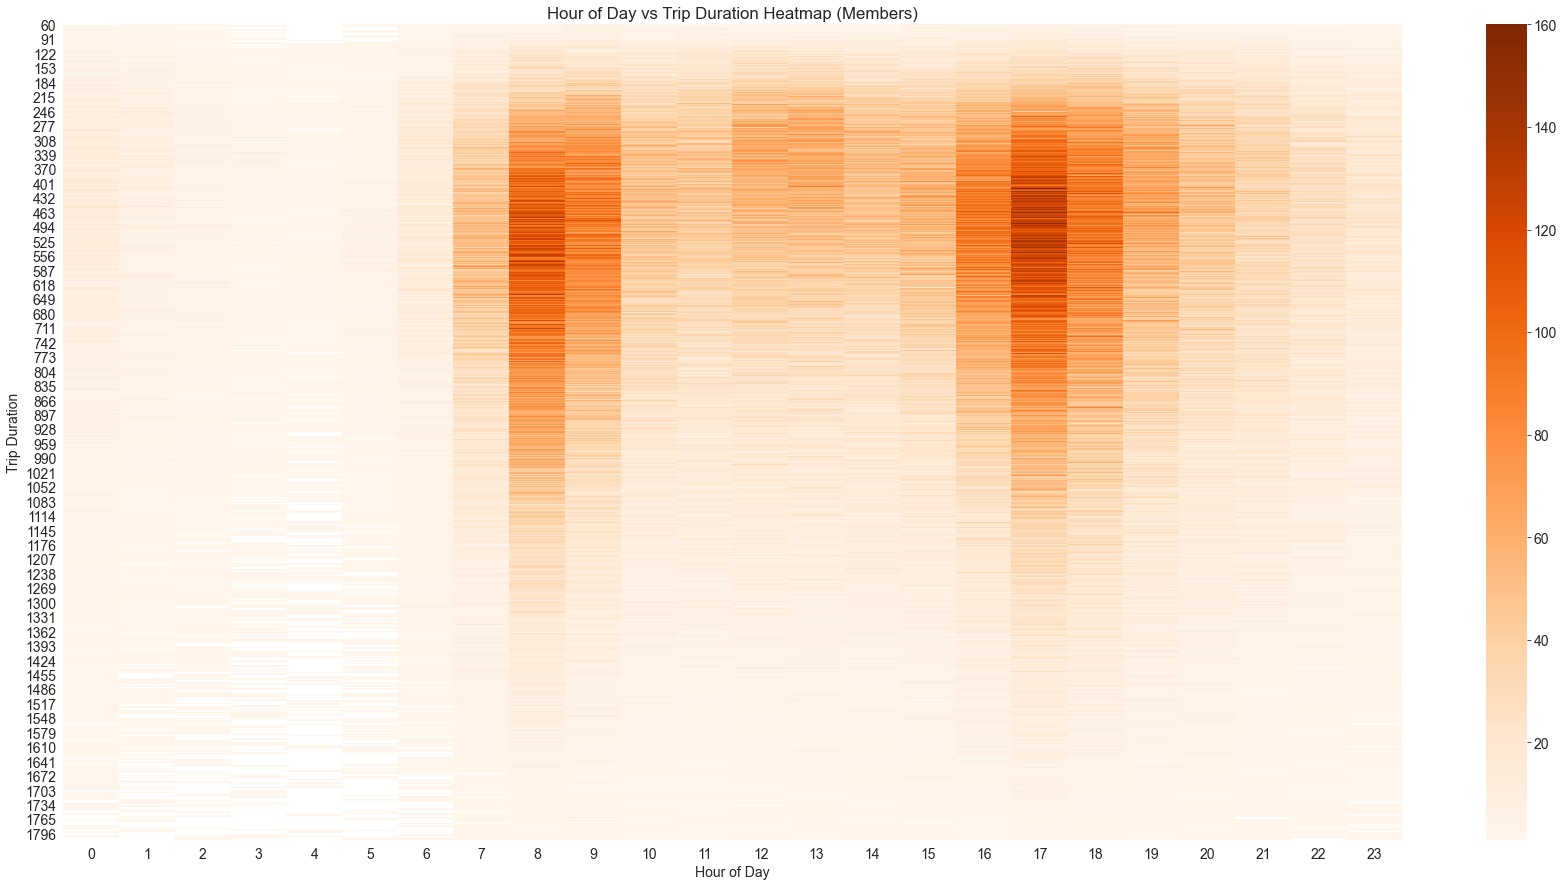

In [24]:
#Taking Member Data, Grouping by Trip Duration and Hour of Day
daily_activity_member = cyclist_df[cyclist_df['user_type'] == 'Member'].groupby(by = ['trip_duration_seconds', 'hour']).count()['user_type'].unstack()

plt.figure(figsize = (30, 15))

sns.heatmap(daily_activity_member, cmap = 'Oranges')

plt.title('Hour of Day vs Trip Duration Heatmap (Members)')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Duration')
plt.savefig('visualization/hour_duration_member.png')

### Daily Activity Heatmap - Casual Riders - Hour of Day vs Trip Duration

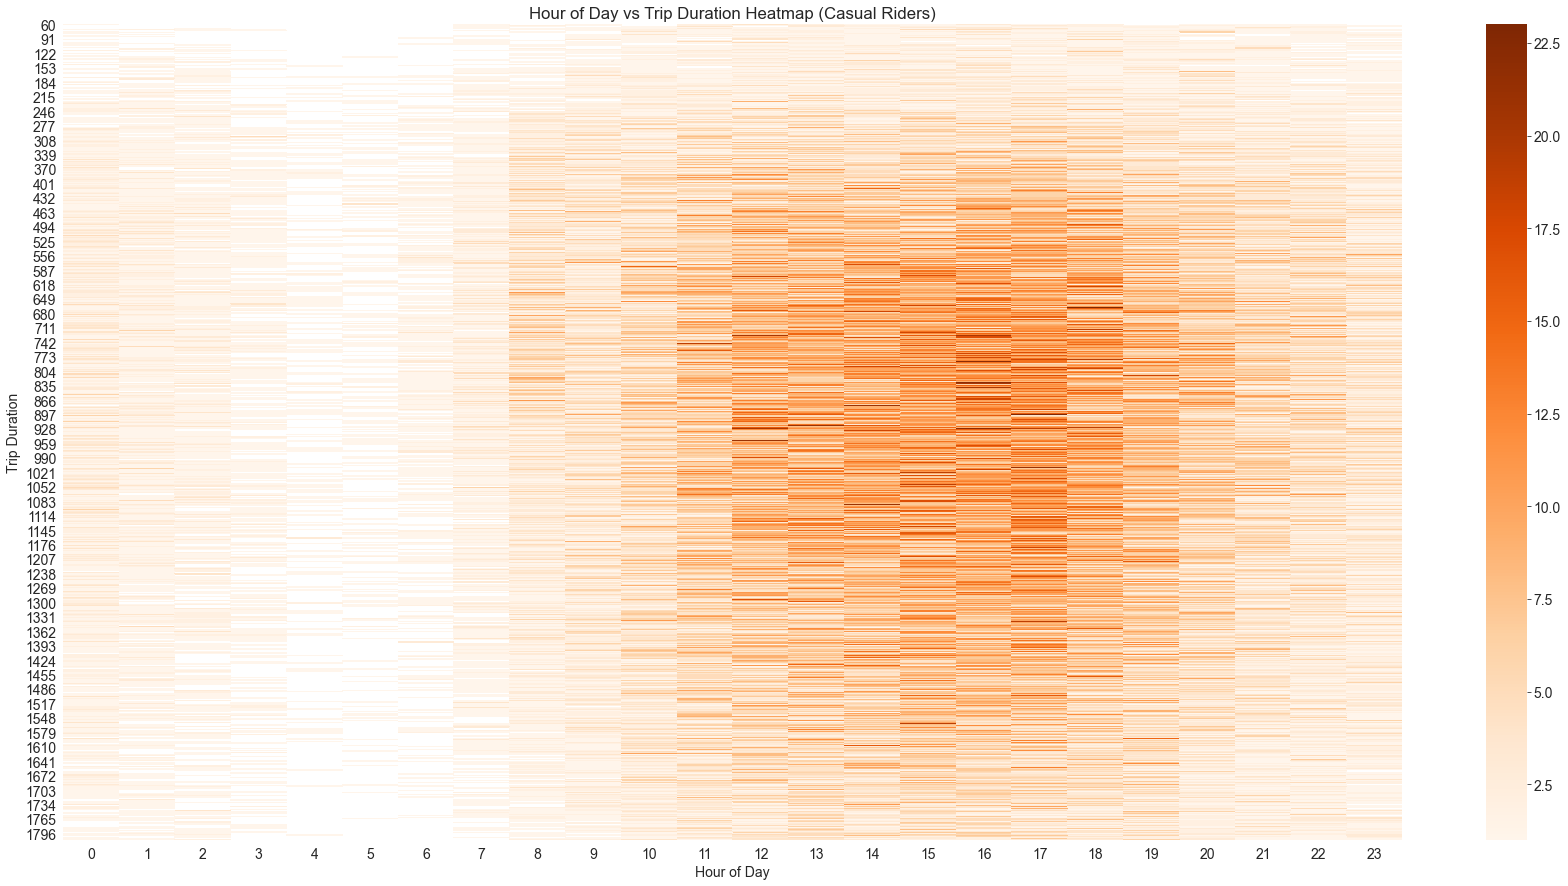

In [25]:
#Taking Casual Riders Data, Grouping by Trip Duration and Hour of Day
daily_activity_casual = cyclist_df[cyclist_df['user_type'] == 'Casual'].groupby(by = ['trip_duration_seconds', 'hour']).count()['user_type'].unstack()

plt.figure(figsize = (30, 15))

sns.heatmap(daily_activity_casual, cmap = 'Oranges')

plt.title('Hour of Day vs Trip Duration Heatmap (Casual Riders)')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Duration')
plt.savefig('visualization/hour_duration_casual.png')

### Busiest Times of the Day

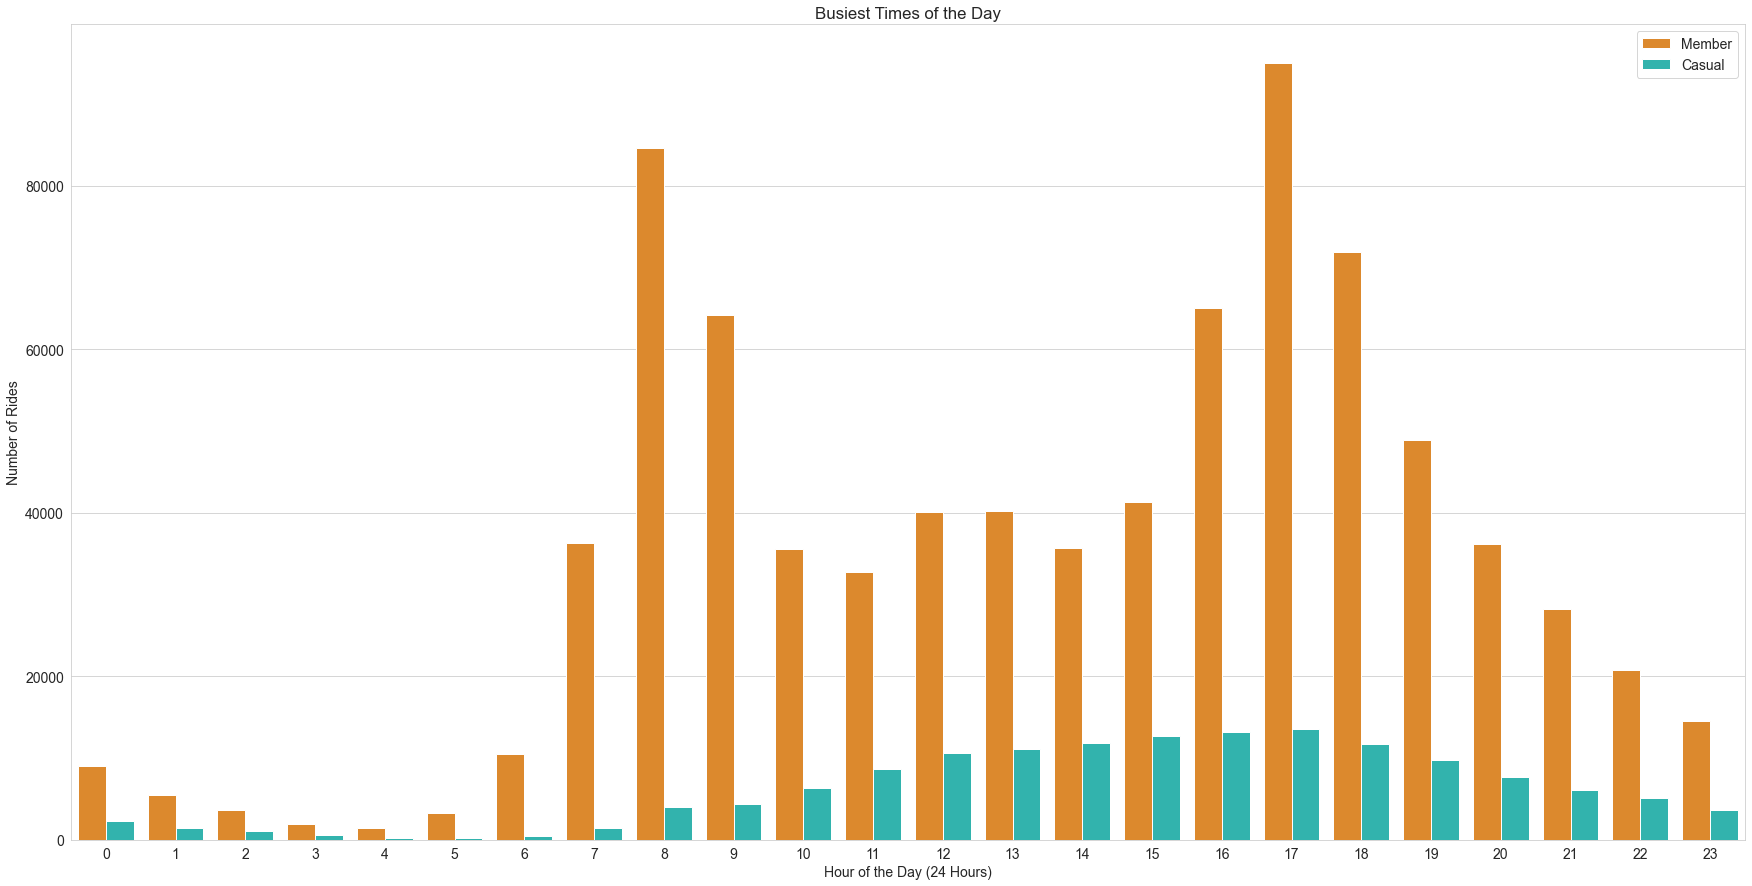

In [26]:
plt.figure(figsize = (30, 15))
sns.set_style('whitegrid')

#Using Seaborn Countplot
ridership = sns.countplot(data = cyclist_df, x = 'hour', hue = 'user_type', palette = ['#F98B10', '#1CC9C0'])

ridership.set(xlabel = 'Hour of the Day (24 Hours)', ylabel = 'Number of Rides')
plt.title('Busiest Times of the Day')
plt.legend();
plt.savefig('visualization/busiest_hour.png')

### Busiest Times of the Week

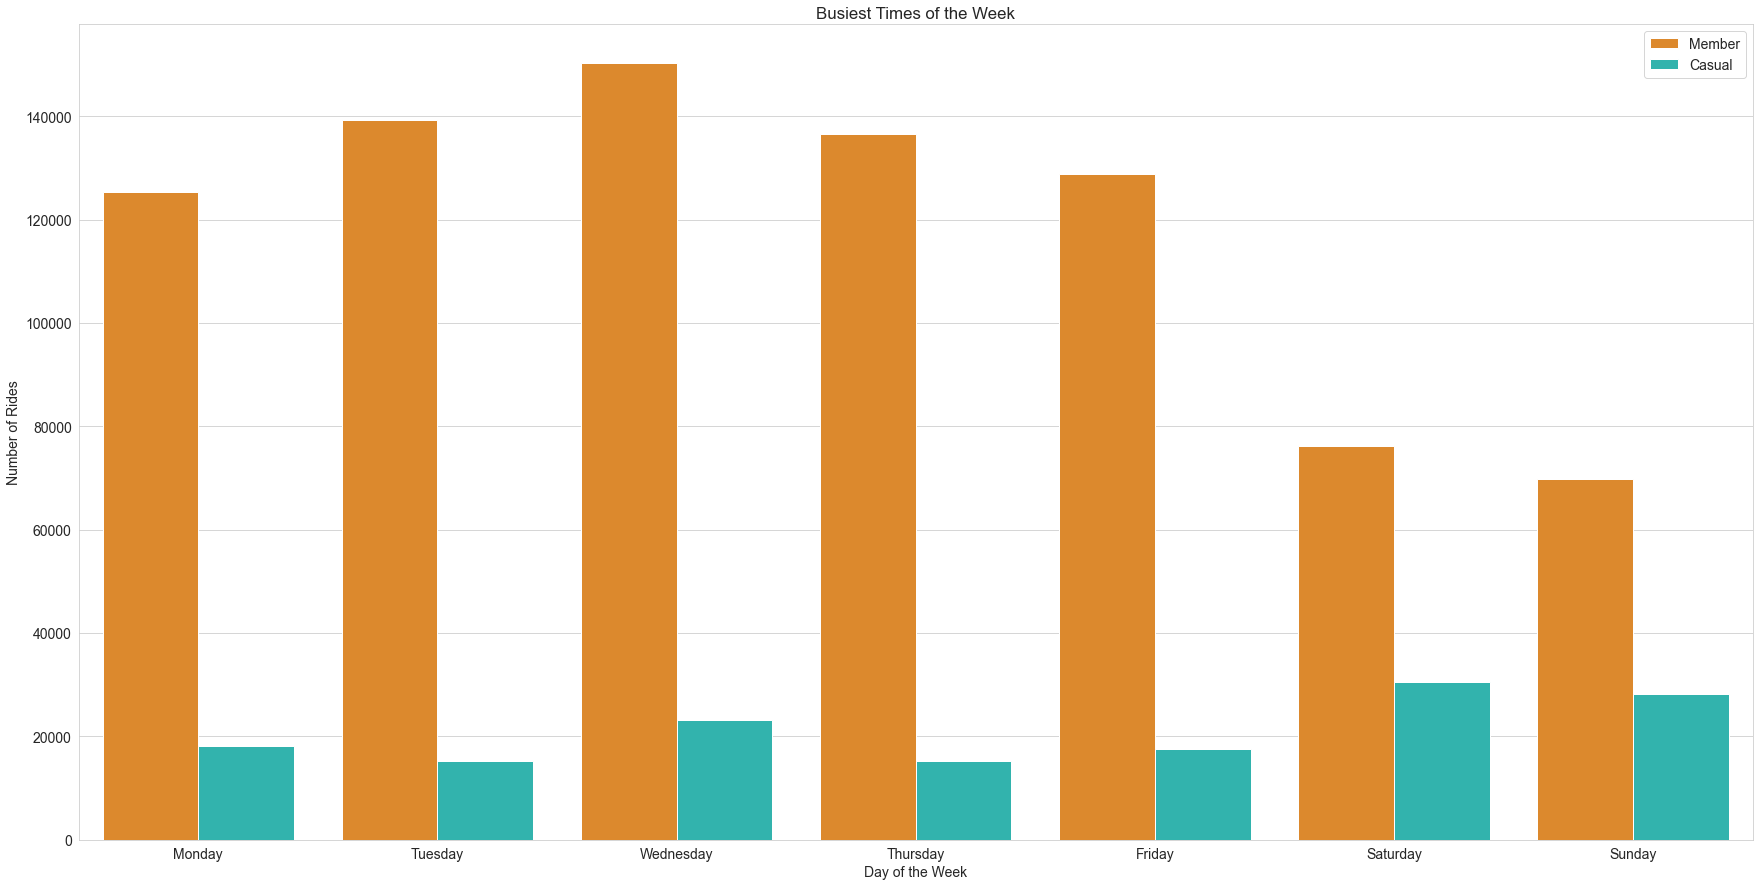

In [27]:
plt.figure(figsize = (30, 15))
sns.set_style('whitegrid')

#Using Seaborn Countplot
ridership = sns.countplot(data = cyclist_df, x = 'day_name', hue = 'user_type', palette = ['#F98B10', '#1CC9C0'], 
                          order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

ridership.set(xlabel = 'Day of the Week', ylabel = 'Number of Rides')
plt.title('Busiest Times of the Week')
plt.legend();
plt.savefig('visualization/busiest_day.png')

### Busiest Times of the Year

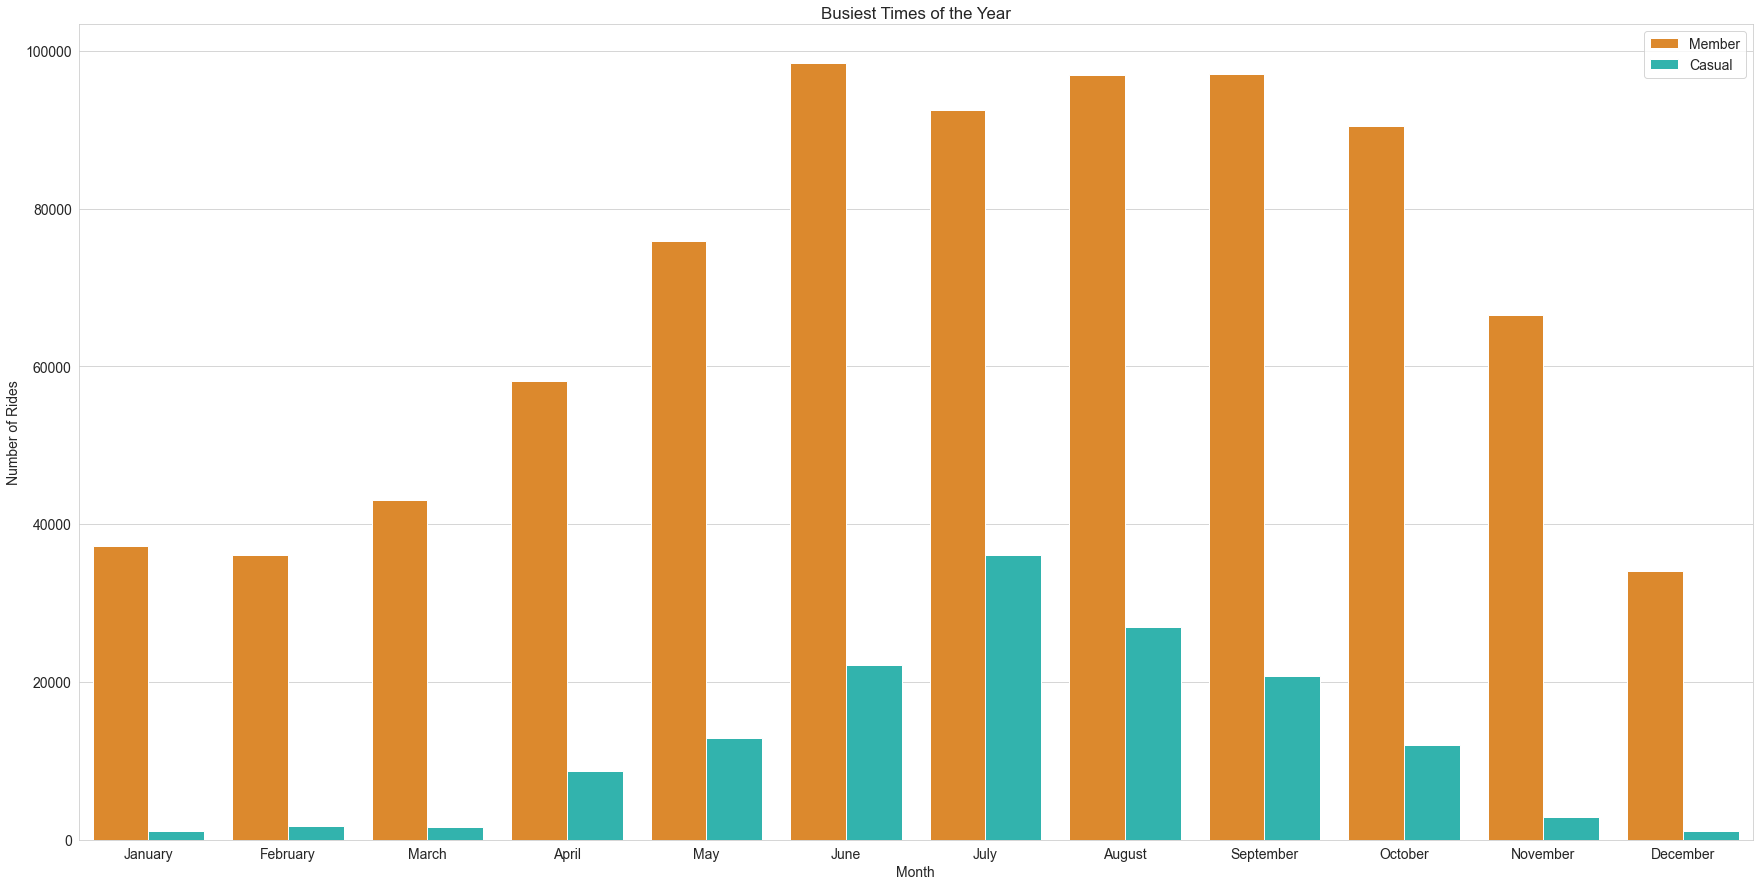

In [28]:
plt.figure(figsize = (30, 15))
sns.set_style("whitegrid")

#Using Seaborn Countplot
ridership = sns.countplot(data = cyclist_df, x = 'month_name', hue = 'user_type', palette = ['#F98B10', '#1CC9C0'], 
                          order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
                                   'October', 'November', 'December'])

ridership.set(xlabel = 'Month', ylabel = 'Number of Rides')
plt.title('Busiest Times of the Year')
plt.legend();
plt.savefig('visualization/busiest_month.png')